# URL Classification

V tomto notebooku bude předveden postup pro natrénování klasifikátorů pomocí knihovny pro [Python](https://www.python.org/) - [scikit-learn](https://scikit-learn.org/).

Popořadě bude ukázáno:

1. načtení dat,
2. analýza dat,
3. transformace vstupních dat,
4. rozdělení dat na *train/test/dev* sady,
5. natrénování klasifikátorů,
6. analýza přesnosti klasifikátorů.

Jako ukázku volím případ binární klasifikace [URL adres](https://tools.ietf.org/html/rfc1738).
Adresa může být buď nezávadná (*good*) nebo závadná - je nějakým způsobem využívána k poškození uživatelů nebo dat.

Začneme imporováním několika základních knihoven a funkcí, které budou použity napříč celým *notebookem*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## Data Loading

Data z *csv* souborů načteme do *pandas dataframe*.
[Pandas](https://pandas.pydata.org/) není nejrychlejší způsob, jak načítat data, je ale pohodlný.

V následujícím bloku kódu definuji cestu k datovým souborům, které následně načítám do jednotlivých *dataframe* struktur, které spojuji do jedné.

In [2]:
import pandas as pd
import glob
import os

# Get data folder
data_folder = os.getcwd() + '\data'
all_files = glob.glob(data_folder + '/*.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

Můžeme se podívat na data, která se načetla.
Pomocí příkazu `head` dostaneme *n* prvních načtených řádek.

In [3]:
frame.head(10)

url label
0                       diaryofagameaddict.com   bad
1                             espdesign.com.au   bad
2                           iamagameaddict.com   bad
3                                kalantzis.net   bad
4                        slightlyoffcenter.net   bad
5                             toddscarwash.com   bad
6                               tubemoviez.com   bad
7                                       ipl.hk   bad
8  crackspider.us/toolbar/install.php?pack=exe   bad
9                              pos-kupang.com/   bad

Vidíme, že data struktura obsahuje dva sloupce - *string* **url** a *řetězec* **label**.
**Label** nabývá hodnot buď *bad*, nebo *good*.
Názvy tříd zadefinuji, budou se využívat často.

In [4]:
from collections import namedtuple

# define class names
Category = namedtuple('Class', 'bad good')
c = Category(bad = 'bad', good = 'good')

## Data Analysis

Data (URL adresy) je třeba analyzovat.
Podívejme se na počet URL řetěců podle tříd.

In [5]:
frame.groupby('label').size()

label
bad     109405
good    344787
dtype: int64

Maximální délka URL řetězce.

In [6]:
frame.url.map(len).max()

2307

Minimální délka URL řetězce.

In [7]:
frame.url.map(len).min()

5

Rozdíl mezi minimální a maximální délkou řetězce je poměrně velký.
Vyzkoušejme vykreslit graf, kde na ose X bude počet *charakterů* v řetězci a na ose Y bude kolikrát se řetězec o dané délce v setu vyskytoval.

In [8]:
def string_length_vs_quantity(df, label='url', subset=None):
    %matplotlib inline
    
    result = dict()
    for index, row in df.iterrows():
        item = row['url']
        length = len(item)
        if length in result:
            result[length] += 1
        else:
            result[length] = 1
    
    # make x axis selection if needed
    if subset:
        temp = dict()
        for key in result.keys():
            if subset[0] < key < subset[1]:
                temp[key] = result[key]
        result = temp
            
    lists = sorted(result.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    
    plt.title("Number of Strings vs String Length")
    plt.bar(x, y)
    plt.ylabel("Number of Strings")
    plt.xlabel("String Length")

Vykreseleme nejdříve rozložení celé množiny dat, nezávisle na třídě.
Parametr `subset` omezuje graf na ose X, po jeho odstranění bude graf zobrazen celý.

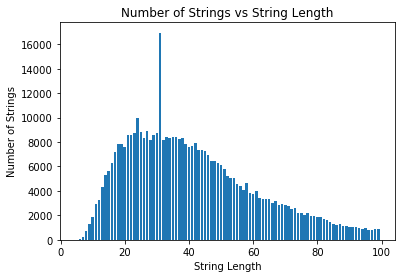

In [9]:
string_length_vs_quantity(frame, subset=(0, 100))

Nyní rozložení pro třídu *bad*.

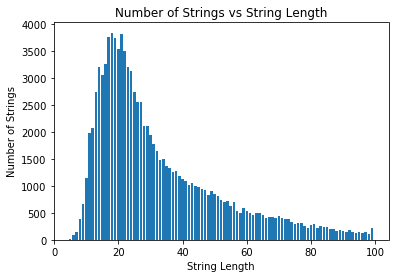

In [10]:
string_length_vs_quantity(frame.loc[frame['label'] == c.bad], subset=(0, 100))

A rozložení pro třídu *good*.

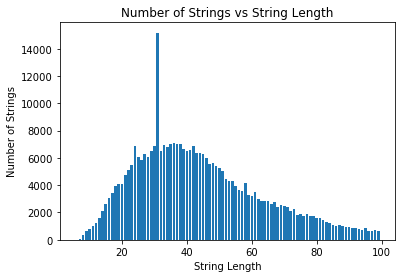

In [11]:
string_length_vs_quantity(frame.loc[frame['label'] == c.good], subset=(0, 100))

## Tokenizace

Nyní máme představu o rozložení dat, podle délky řetězců.

Příznaky, které budeme pro klasifikaci používat však nejsou jednotlivé *charaktery* řetězce.
Způsob, který chci prezentovat tkví ve vytvoření smysluplných příznaků - rozdělení URL na jednotlivá slova.

Pro tento účel použijeme knihovnu [wordninja](https://github.com/keredson/wordninja), která obsahuje jedinou funkci - `split`. Knihovna vychází z řešení dotazu na StackOverflow - [How to split text without spaces into list of words?](https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words/11642687#11642687).

Knihovna využívá dynamického programování a je poměrně jednoduchá, doporučuji tedy, projít si v případě zájmu kód.
Nevýhodou v tomto případě je to, že algoritmus pro své fungování vyžaduje seznam slov seřazených podle frekvencí výskytu od největšího po nejmenší.
*Wordninja* využívá seznam obsahující anglické výrazy.
Korpus tedy nemusí nutně vyhovovat datům, na která ho budeme aplikovat, ale nějak fungovat bude.
Když se algortimus setká s řetězcem, který nemůže smysluplně rozdělit, tak ho rozdělí tak, aby minimalizoval cenu rozdělení.

Importujeme knihovnu a vytvoříme funkci, která odvodí pozici mezer v řetězci a převede slova malá písmena.
Kdybychom vynechali krok, kde unifikujeme velikost písmen, tak by se mohlo stát, že dostaneme jedno slovo jednou s velkým počátečním písmenem, podruhé s malým.
Toto slovo by pak tvořilo dva příznaky v matici příznaků, čemuž se chci vyhnout.

In [12]:
import wordninja

# define tokenizer function
def get_tokens(url: str, blacklist=None) -> list:
    tokens = wordninja.split(url)
    if blacklist:
        tokens = (x.lower() for x in tokens)
        tokens = [x for x in tokens if x not in blacklist]
        return tokens
    else:
        return (x.lower() for x in tokens)

Vyzkoušíme funkčnost metody na příkladu.

In [13]:
list(get_tokens('ThEqUiCkBrOwNfoxjumpsovertHelazydog'))

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

A vyzkoušíme jeho nefunkčnost.

In [14]:
list(get_tokens('prvníAlgoritmusTohotoDruhu'))

['pr', 'v', 'n', 'a', 'lg', 'or', 'it', 'must', 'oho', 'tod', 'ruh', 'u']

V rámci tokenizace zadefinuji ještě slova, která nechci, aby se vyskytovala v příznacích.
V URL adresách jsou typické výrazy jako *com*, *www*, *http*, *https*, která se vytují prakticky pokaždé a nemají tedy žádnou reálnou výpovědní hodnotu.

In [15]:
# removing some words, they occur a lot of times and shouldn't be included in our features
unwanted_words = ('com', 'www', 'http', 'https')

Podívejme se, jak se změní rozložení dat, když budeme jako tokeny využívat slova, která inferuje *tokenizer*.

In [16]:
def string_tokens_vs_quantity(df, label='url', subset=None):
    %matplotlib inline
    
    result = dict()
    for index, row in df.iterrows():
        item = row['url']
        token = len(list(get_tokens(item, unwanted_words)))
        if token in result:
            result[token] += 1
        else:
            result[token] = 1
            
    # make x axis selection if needed
    if subset:
        temp = dict()
        for key in result.keys():
            if subset[0] < key < subset[1]:
                temp[key] = result[key]
        result = temp
        
    lists = sorted(result.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
                              
    plt.title("Number of Strings vs Token Count")
    plt.bar(x, y)
    plt.ylabel("Number of Strings")
    plt.xlabel("Token Count")

Rozložení pro celý *dataframe*.

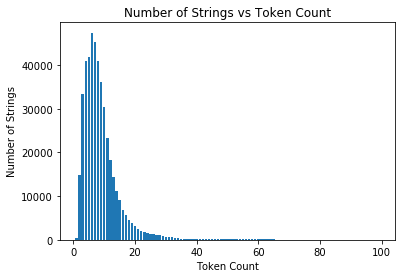

In [17]:
string_tokens_vs_quantity(frame, subset=(0, 100))

Rozložení pro třídu *bad*.

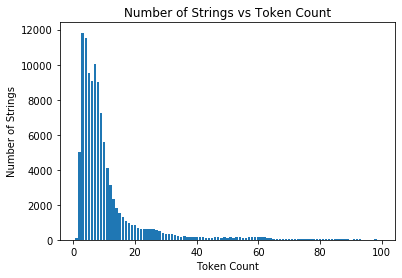

In [18]:
string_tokens_vs_quantity(frame.loc[frame['label'] == c.bad], subset=(0, 100))

Rozložení pro třídu *good*.

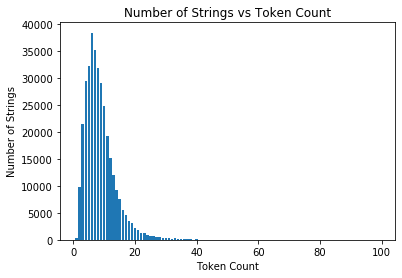

In [19]:
string_tokens_vs_quantity(frame.loc[frame['label'] == c.good], subset=(0, 100))

## Vectorizer

Abychom mohli převést kolekci URL adres na matici příznaků (*features*), tak potřebujeme definovat funkci, která to provede.
Takovou funkcí je *tokenizer*, v našem případě *term-frequency times inverse document-frequency vectorizer*.

[TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) znamená, že četnost slova v dokumentu (URL) se podělí četností slova ve všech dokumentech.

In [20]:
# get a vector for each url but use our customized tokenizer
vectorizer = TfidfVectorizer(tokenizer=get_tokens, stop_words=unwanted_words)

Matice přízanků, která po vektorizaci vznikne bude velice řídká (*sparse*), protože příznaků bude velké množství (každé rozpoznané slovo tvoří jeden příznak), ale každá URL obsahuje jen malé množství příznaků (naprostá většina URL adres bude mít do 20 příznaků, zatímco unikátních příznaků bude pravděpodobně více jak 500,000).
Na tuto skutečnost je potřeba dávat při volbě klasifikátoru/regresoru, jelikož ne všechny přijímají na vstup řídké matice.

## Datasets

Ve strojovém učení jsou potřeba tři datasety.

Trénovací set, jak název napovídá, je použit k natrénování klasifikátoru/regresoru.
Měla by ho tvořit většina dat, která máme k dispozici.

Vývojový (development) set, se používá pro evaluaci klasifikátoru/regresoru se požívá při vývoji - pro zkoušení různých konfigurací nebo různých reprezentací příznaků.

Test set tvoří data, která která slouží k otestování přesnosti modelu.

**Poznámka:** Dev data by měla být co nejpodobnější testovacím datům a testovací data by měla být co nejpodobnější reálným datům.
Data v síťovém provozu (*network traffic*) budou extrémně biasovaná - většina provozu bude klasifikována jako nezávadná a jen nepatrná část bude vykazovat známky záškodnictví.
Tomuto fenoménu se budeme snažit přiblížit tím, že *dev* a *test* data vytvoříme v biasovaném poměru.

### Training

Pro trénovací účely vytvoříme dataset se stejným počtem vzorků z obou tříd.
Doporučuji vyzkoušet si, jak se bude klasifikátor a výkonnostní metriky chovat, když by byl trénovací set také biasovaný.

Proces úpravy dat je následovný:

1. vyberu počet závadých prvků,
2. vyberu počet nezávadných prvků,
3. spojím data z 1. a 2. do jednoho *dataframe*,
4. konvertuji *dataframe* do *numpy array*,
5. zamíchám data,
6. vyberu vektor označení (*labels* - *good* or *bad*),
7. vyberu vektor URL adres,
8. transformuji vektor URL adres na matici příznaků **X**.

In [21]:
# select n random samples with label 'bad'
frame_bad = frame.loc[frame['label'] == c.bad].sample(n=50000)

# select n random samples with label 'good'
frame_good = frame.loc[frame['label'] == c.good].sample(n=50000)

# join selections
df = frame_good.append(frame_bad, ignore_index=True)

# convert dataframe into an array
dfa = np.array(df)

# shuffle data
np.random.shuffle(dfa)

# all labels
y_train = [d[1] for d in dfa]

# all urls corresponding to a label (either good or bad)
corpus = [d[0] for d in dfa]

# get the X vector
x_train = vectorizer.fit_transform(corpus)

Podívejme se, jaký je po natrénování počet příznaků.

In [22]:
# Get the count of explicitly-stored values (nonzeros)
features_no = x_train.getnnz(axis=0)
print('number of features: {}'.format(sum(features_no)))

number of features: 927774


### Testing

Testovací set je biasovaný - je *n* násobně větší počet vzorků z třídy nezávadných prvků.

In [23]:
# select n random samples with label 'bad'
frame_bad = frame.loc[frame['label'] == c.bad].sample(n=250)

# select n random samples with label 'good'
frame_good = frame.loc[frame['label'] == c.good].sample(n=25000)

# join selections
df = frame_good.append(frame_bad, ignore_index=True)

# convert dataframe into an array
dfa = np.array(df)

# shuffle data
np.random.shuffle(dfa)

# all labels
y_test = [d[1] for d in dfa]

# all urls corresponding to a label (either good or bad)
corpus = [d[0] for d in dfa]

# get the X vector
x_test = vectorizer.transform(corpus)

### Development

*Dev* set vytvořím rozdělením testovacích dat v poměru 80 % testovacích dat a 20 % *dev* dat.

In [24]:
# split into training and testing set (e.g. 80/20 ratio)
x_test, x_dev, y_test, y_dev = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

## Classifiers

Inicializace a trénování klasifikátorů je pomocí *scikit-learn* poměrně jednoduché.
Stačí naimportovat kýženou metodu, kterou si lze vybrat buď ze stránky [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) nebo z [API Reference](https://scikit-learn.org/stable/modules/classes.html).

Importovanou metodu je nutné zavolat s požadovanými parametry, např. `SGDClassifier(loss='log', max_iter=1000)`, v tomto případě na paramaetrech příliš nezáleží.

Natrénování klasifikátoru proběhne po zavolání metody `fit()` na trénovacích datech.

**Poznámka:** jak jsem již zmiňoval výše, tak při výběru klasifikátoru je nutné brát v úvahu, jestli daná implementace umí pracovat s řídkou matickí příznaků na vstupu.


### Linear SVM with Stochastic gradient descent

Viz [dokumentaci](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html).

In [25]:
from sklearn.linear_model import SGDClassifier

sgd = {
    'label' : 'SGDClassifier',
    'model': SGDClassifier(loss='log', max_iter=1000)
}

# time model training
%time sgd['model'].fit(x_train, y_train)

Wall time: 288 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Logistic Regression

Viz [dokumentaci](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [26]:
from sklearn.linear_model import LogisticRegression

lrc = {
    'label' : 'LogisticRegression',
    'model': LogisticRegression(solver='warn')
}

%time lrc['model'].fit(x_train, y_train)

C:\ProgramData\Miniconda3\envs\prj4\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 1.29 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Performance

Existuje několik způsobů, jak evaluovat klasifikátor, např.:

1. confusion matrix,
2. F1-score,
3. G-score,
4. accuracy,
5. AUROC.

Materiálů zabývajících se tímto tématem je spousta.
Doporučuji například dvoudílný článek **The Basics of Classifier Evaluation**.

* [The Basics of Classifier Evaluation, Part 1](https://www.svds.com/the-basics-of-classifier-evaluation-part-1/)
* [The Basics of Classifier Evaluation, Part 2](https://www.svds.com/classifiers2/)

### Classification report

Abychom byli schopni evaluovat naše natrénované klasifikátory, tak nejdříve zavedeme 2 funkce.

Funkce report využívá standartní funkci *scikit-learn* - `classification_report`, která vypíše klasifikační report - precision, recall a F1 míru.
Definujeme jí tedy prakticky znovu, jen s drobnou obměnou tak, abychom byli schopni nastavit jiný klasifikační práh, než je výchozí hodnota `0.5`.

In [27]:
from sklearn.metrics import classification_report

def report(clf, x_metric, y_metric, threshold=.5, output_dict=False):
    y_pred = list()
    for item in clf.predict_proba(x_metric)[:,1]:
        if item >= threshold: # set threshold, default threshold is 0.5
            y_pred.append(c.good)
        else:
            y_pred.append(c.bad)
    
    report = classification_report(y_metric, y_pred, target_names=tuple(c), output_dict=output_dict)
    return report

Druhá funkce je na vykreslení precision, recall a F1 míry pro různé prahy (*thresholds*) do jednoho grafu.
V místě, kde se precision a recall protínají je ideální práh, který bychom chtěli použít v klasifikačním reportu.
Práh je tedy vedle grafu výstupem této metody.

In [28]:
from sklearn.metrics import precision_recall_curve

def pr_threshold(clf, x_metric, y_metric):
    %matplotlib inline
    probs_y = clf['model'].predict_proba(x_metric)
    
    bool_reals = [item == 'good' for item in y_metric]
    precision, recall, thresholds = precision_recall_curve(bool_reals, probs_y[:, 1]) 
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    idx = np.argwhere(np.diff(np.sign(precision - recall))).flatten()
    thresh = np.mean(thresholds[idx])
    
    plt.title("Precision-Recall-F1 vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.plot(thresholds, f1_score[: -1], "y--", label="F1-score")
    plt.plot(thresholds[idx], f1_score[idx], 'ro')
    plt.ylabel("Precision, Recall, F1")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])
    
    return thresh

Evaluaci spustíme nad vývojovými daty s výchozím prahem.

In [29]:
print(report(sgd['model'], x_dev, y_dev))

              precision    recall  f1-score   support

         bad       0.09      0.88      0.16        40
        good       1.00      0.93      0.96      5010

    accuracy                           0.93      5050
   macro avg       0.54      0.90      0.56      5050
weighted avg       0.99      0.93      0.96      5050



Určíme optimální práh.

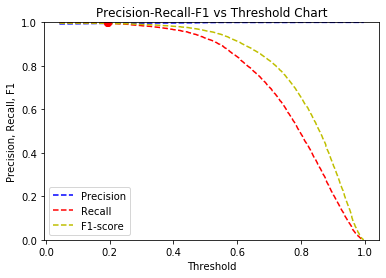

In [30]:
sgd_thresh = pr_threshold(sgd, x_dev, y_dev)

Použijeme vypočtený práh pro vygenerování nového klasifikačního reportu.

In [31]:
print(report(sgd['model'], x_dev, y_dev, threshold=sgd_thresh))

              precision    recall  f1-score   support

         bad       0.42      0.42      0.42        40
        good       1.00      1.00      1.00      5010

    accuracy                           0.99      5050
   macro avg       0.71      0.71      0.71      5050
weighted avg       0.99      0.99      0.99      5050



Při použití vypočteného prahu se F1 míra pro třídu závadných vzorků zvýšila.

### AUC and ROC curve

Poslední metrikou, kterou zkusíme evaluovat klasifikátor je Receiver Operating Characteristics křivka a *Area Under The Curve*. Tato charakteristika vyjadřuje, jak je model schopný rozlišovat mezi třídami.

O této křivce pojednává např. článek [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

Zadefinujeme si *list*, ve kterém budou všechny klasifikátory, které chceme do ROC zahrnout.

In [32]:
clfs = [sgd, lrc]

Definujeme funkci pro vykreslení křivky.

In [33]:
from sklearn.metrics import roc_curve, auc 
    
def plot_roc(models, x_metric, y_metric):
    %matplotlib inline
    
    for m in models:
        probas = m['model'].predict_proba(x_metric)
        fpr, tpr, thresholds = roc_curve(y_metric, probas[:, 1], pos_label=c.good)
        roc_auc  = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s (area = %0.2f)' % (m['label'], roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

A vykreslíme ji na testovacích datech.

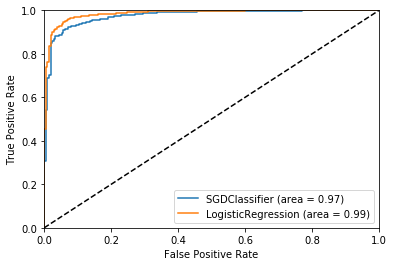

In [34]:
plot_roc(clfs, x_test, y_test)

Čím vyšší je hodnota AUC, tím lépe by si měl klasifikátor vést při rozlišování mezi třídami. 